In [35]:
import os
import argparse
import requests
import json

from io import BytesIO
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import Audio

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchaudio

from dataset_utils import BimodalDataset, create_dataset
from pytorch_msssim import ssim
from models import load_model

from utils import unnorm, load_image, di, norm

import sys
sys.path.insert(0,'/home/tz362/Desktop/projects/DiffJPEG') 
from DiffJPEG import DiffJPEG

device="cuda:0"
modality="vision"
model = load_model("imagebind", device)
batch_size = 1
seed=0
image_text_dataset = create_dataset("imagenet", model=model, device=device, embs_input="outputs/embeddings/imagenet_imagebind_embeddings.npy")
dataloader = DataLoader(image_text_dataset, batch_size=batch_size, shuffle=True)

IMG_MEAN=(0.48145466, 0.4578275, 0.40821073)
IMG_STD=(0.26862954, 0.26130258, 0.27577711)

def unnorm(tensor, mean=IMG_MEAN, std=IMG_STD):
    m = torch.tensor(IMG_MEAN)[None, :, None, None].to(device)
    s = torch.tensor(IMG_STD)[None, :, None, None].to(device)
    return (tensor.clone().to(device) * s) + m

def norm(tensor, mean=IMG_MEAN, std=IMG_STD):
    m = torch.tensor(IMG_MEAN)[None, :, None, None].to(device)
    s = torch.tensor(IMG_STD)[None, :, None, None].to(device)
    return (tensor.clone().to(device) - m) / s

transform = transforms.ToPILImage()
criterion = F.cosine_similarity

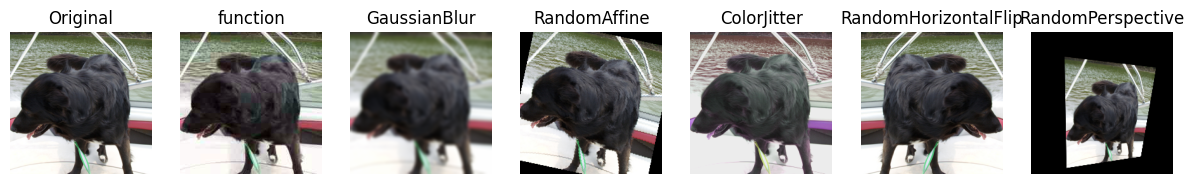

In [36]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def jpeg_transform(X):
    image_filename = 'dummy.jpg'
    save_image(torch.squeeze(unnorm(X)), image_filename)
    jpeg_X = data.load_and_transform_vision_data([image_filename], device)
    os.remove(image_filename)
    jpeg_X=jpeg_X.clamp(0,1)
    return jpeg_X.squeeze().cpu()

# Define a list of transformations to apply
transformations = [
    jpeg_transform,
    transforms.GaussianBlur(kernel_size=9, sigma=(1.0, 5.0)),
    transforms.RandomAffine(degrees=45),  # Rotate by 45 degrees
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
]
torch.manual_seed(0)
# Function to apply transformations and plot
def apply_transformations_and_plot(dataloader, transformations):
    for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
        X=unnorm(X)
        # Apply each transformation to the same image for comparison
        # We take the first image in the batch for demonstration purposes using X[0]
        fig, axs = plt.subplots(1, len(transformations) + 1, figsize=(15, 10))  # +1 for the original image
        
        # Plot original image
        axs[0].imshow(X[0].detach().cpu().permute(1, 2, 0))  # Permute to convert from CxHxW to HxWxC for plotting
        axs[0].set_title('Original')
        axs[0].axis('off')

        # Plot transformed images
        for ax, transform in zip(axs[1:], transformations):
            transformed_image = transform(X[0].detach().cpu())  # Apply transformation
            ax.imshow(transformed_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
            ax.set_title(transform.__class__.__name__)
            ax.axis('off')

        plt.show()
        break  # Only show the first batch for brevity

# Call the function with the dummy_loader and the list of transformations
apply_transformations_and_plot(dataloader, transformations)


In [37]:
criterion = F.cosine_similarity
similarity_transform=[0,0,0,0,0,0]
n=100
for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
    with torch.no_grad():
        embeds = model.forward(X, modality, normalize=False)
        for j, transform in enumerate(transformations):
            transformed_image = norm(transform(unnorm(X).detach().cpu()))  # Apply transformation
            transformed_embeds = model.forward(transformed_image, modality, normalize=False)
            similarity_transform[j]+=criterion(embeds[:, None, :], transformed_embeds[:, None, :], dim=2)[0][0].item()
        if i == n-1:
            break

for transform, sim in zip(transformations,similarity_transform):    
    print(str(transform.__class__.__name__), sim/n)

function 0.8320847767591476
GaussianBlur 0.7975125360488892
RandomAffine 0.8821750354766845
ColorJitter 0.9112309426069259
RandomHorizontalFlip 0.9695964646339417
RandomPerspective 0.9352121096849442


In [42]:
X_advs = np.load('outputs/imagenet/whitebox/audioclip/x_advs_300.npy')
X_advs=torch.tensor(X_advs).to(device)

criterion = F.cosine_similarity
similarity_transform=[0,0,0,0,0,0]
n=100
for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
    X=X_advs[i].unsqueeze(0)
    with torch.no_grad():
        embeds = model.forward(X, modality, normalize=False)
        for j, transform in enumerate(transformations):
            transformed_image = norm(transform(unnorm(X).detach().cpu()))  # Apply transformation
            transformed_embeds = model.forward(transformed_image, modality, normalize=False)
            similarity_transform[j]+=criterion(embeds[:, None, :], transformed_embeds[:, None, :], dim=2)[0][0].item()
        if i == n-1:
            break

for transform, sim in zip(transformations,similarity_transform):    
    print(str(transform.__class__.__name__), sim/n)

function 0.36648342981934545
GaussianBlur 0.3559121680259705
RandomAffine 0.38947749629616735
ColorJitter 0.5900252142548561
RandomHorizontalFlip 0.4283366110920906
RandomPerspective 0.6847422926127911


In [ ]:
X_jpeg = np.load('outputs/imagenet/whitebox/imagebind_jpeg/x_advs_300.npy')
X_jpeg=torch.tensor(X_jpeg).to(device)

criterion = F.cosine_similarity
similarity_transform=[0,0,0,0,0,0]
n=100
for i, (X, Y, gt, y_id, orig_label) in enumerate(dataloader):
    X=X_jpeg[i].unsqueeze(0)
    with torch.no_grad():
        embeds = model.forward(X, modality, normalize=False)
        for j, transform in enumerate(transformations):
            transformed_image = norm(transform(unnorm(X).detach().cpu()))  # Apply transformation
            transformed_embeds = model.forward(transformed_image, modality, normalize=False)
            similarity_transform[j]+=criterion(embeds[:, None, :], transformed_embeds[:, None, :], dim=2)[0][0].item()
        if i == n-1:
            break

for transform, sim in zip(transformations,similarity_transform):    
    print(str(transform.__class__.__name__), sim/n)